# AIM

AIM of this Notebook is to explore our dataset based on the tokenizer we exported
AIM of this Notebook is to calculate the records that are having more than 10,000 tokens in our custom dataset

## Unzip Files

we have exported fine-tuned models before to zip file so we are now unzipping them to folders

`llama3b_3_2` is supposed to contain the fine-tuned model (LLMA 3B 3.2 Model fintuned with the TL;DR dataset and then the Custom Dataset)

In [5]:
!unzip llama_3b_3_2.zip

Archive:  llama_3b_3_2.zip
   creating: llama3.2-3b-qlora-summary/
  inflating: llama3.2-3b-qlora-summary/tokenizer.json  
  inflating: llama3.2-3b-qlora-summary/adapter_config.json  
  inflating: llama3.2-3b-qlora-summary/tokenizer_config.json  
  inflating: llama3.2-3b-qlora-summary/README.md  
  inflating: llama3.2-3b-qlora-summary/chat_template.jinja  
  inflating: llama3.2-3b-qlora-summary/special_tokens_map.json  
   creating: llama3.2-3b-qlora-summary/checkpoint-300/
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/tokenizer.json  
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/adapter_config.json  
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/scheduler.pt  
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/tokenizer_config.json  
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/README.md  
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/chat_template.jinja  
  inflating: llama3.2-3b-qlora-summary/checkpoint-300/special_tokens_map.json  
  inf

## Install Packages

we are regularly adding these code cells to install the packages as this notebook was run in Colab

In [3]:
!pip install pandas datasets

In [1]:
!pip install transformers torch

In [2]:
!pip install xformers trl peft accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 122.9/122.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 899.7/899.7 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 594.3/594.3 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.0/88.0 MB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 954.8/954.8 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 706.8/706.8 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.1/193.1 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 59.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.6/63.6 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.5/267.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28

In [17]:
import json
from datasets import Dataset
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

## Note

we are assuming the zip folder was unzipped in this current working directory to `llama3.2-3b-qlora-summary`

In [7]:
BASE_MODEL = "meta-llama/Llama-3.2-3B-Instruct"
ADAPTER_PATH = "./llama3.2-3b-qlora-summary"

In [8]:
tokenizer = AutoTokenizer.from_pretrained(ADAPTER_PATH)

In [12]:
# Load JSONL data (Custom Dataset)
print("\n2-[1/8] Loading dataset...")
data = []
with open("custom_dataset.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

custom_dataset = Dataset.from_dict({
    "messages": [item["messages"] for item in data]
})

print(f"✓ Loaded {len(custom_dataset)} examples")


2-[1/8] Loading dataset...
✓ Loaded 1102 examples


In [14]:
def format_and_tokenize(example, force=4096):
    # Apply LLaMA chat template
    formatted_text = tokenizer.apply_chat_template(
        example["messages"],
        tokenize=False,
        add_generation_prompt=False
    )

    # Tokenize (NO padding, NO manual labels)
    tokenized = tokenizer(
        formatted_text,
        truncation=True,
        max_length=force,   # IMPORTANT: increase for long transcripts
        padding=False,
    )

    return tokenized


## Tokenize Custom Dataset

after loading the tokenizer from the export we are now tokenizing the custom dataset

In [28]:
limit = 10_000

format_and_tokenize_for_cds = lambda x: format_and_tokenize(x, force=limit)

In [29]:
tokenized_custom_dataset = custom_dataset.map(
    format_and_tokenize_for_cds,
    remove_columns=["messages"],
    batched=False,
    desc="Tokenizing train"
)

Tokenizing train:   0%|          | 0/1102 [00:00<?, ? examples/s]

## Plot Token Lengths

we are now plotting the token lengths to see how many records are having more than 10,000 tokens

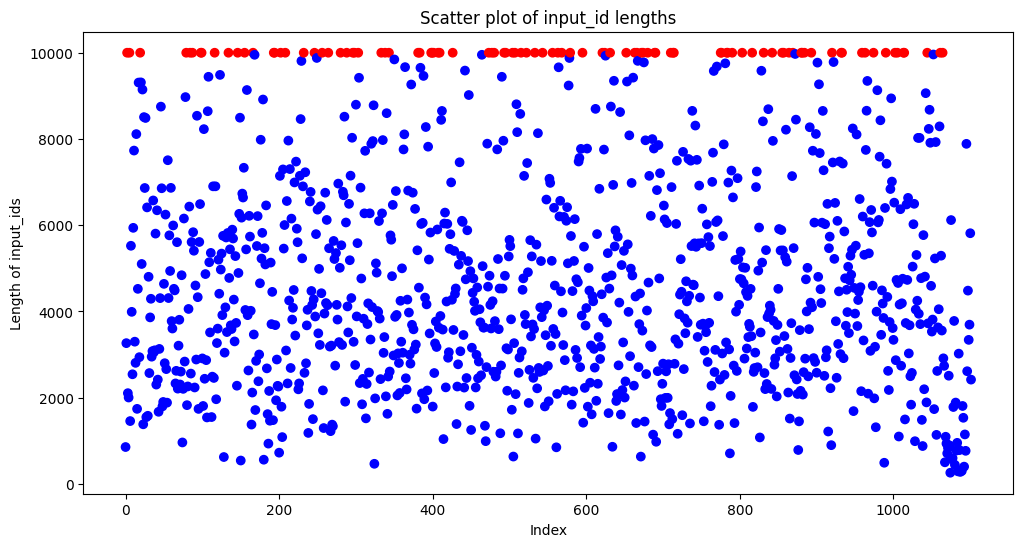

In [30]:
sie = []
note = []

for index, _ in enumerate(tokenized_custom_dataset):
    if len(_['input_ids']) == limit:
        note.append(index)
    sie.append(len(_['input_ids']))

# Create a color list: red if in note, blue otherwise
colors = ['red' if i in note else 'blue' for i in range(len(sie))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(sie)), sie, c=colors)
plt.xlabel("Index")
plt.ylabel("Length of input_ids")
plt.title("Scatter plot of input_id lengths")
plt.show()


In [31]:
"Loss: ", len(note)

('Loss: ', 98)

## Observation

we have observed 98 Records were exceeding the token limit of 10,000. we have decided on 10,000 based on the trade-off between the GPU power we have and the datasize

## Generate SQL Script

Since we are saving the Custom Dataset in sqlite we are generating the sql script to delete those records which are exceeding the token limit of 10,000

In [38]:
import regex

script = """"""
pattern = r"USER PROMPT:\s*([\s\S]*?)(?:\nVIDEO TRANSCRIPTS|\Z)"

for index in note:
    result = regex.findall(pattern, custom_dataset[index]["messages"][1]["content"])
    script += f"delete from `PromptResults` where SearchPrompt = '{result[0].replace("'", "''")}';\n"

print(script)

delete from `PromptResults` where SearchPrompt = 'how to grow tomatoes in containers';
delete from `PromptResults` where SearchPrompt = 'why is nuclear waste dangerous';
delete from `PromptResults` where SearchPrompt = 'what is folk psychology';
delete from `PromptResults` where SearchPrompt = 'how to clean carburetor';
delete from `PromptResults` where SearchPrompt = 'why is methanol toxic';
delete from `PromptResults` where SearchPrompt = 'how to make fried rice perfectly';
delete from `PromptResults` where SearchPrompt = 'what is blockchain technology';
delete from `PromptResults` where SearchPrompt = 'why do wolves hunt in packs';
delete from `PromptResults` where SearchPrompt = 'how to make po boy sandwich';
delete from `PromptResults` where SearchPrompt = 'what is philosophical zombies';
delete from `PromptResults` where SearchPrompt = 'how to make french macarons';
delete from `PromptResults` where SearchPrompt = 'why do lanternfish have photophores';
delete from `PromptResults`

# After the Deletion

we are reloading the dataset and checking if there's still any records exceeding the token limit of 10,000

In [39]:
# Load JSONL data (Custom Dataset)
print("\n2-[1/8] Loading dataset...")
data = []
with open("custom_dataset.jsonl", "r") as f:
    for line in f:
        data.append(json.loads(line))

custom_dataset = Dataset.from_dict({
    "messages": [item["messages"] for item in data]
})

print(f"✓ Loaded {len(custom_dataset)} examples")


2-[1/8] Loading dataset...
✓ Loaded 1004 examples


In [40]:
tokenized_custom_dataset = custom_dataset.map(
    format_and_tokenize_for_cds,
    remove_columns=["messages"],
    batched=False,
    desc="Tokenizing train"
)

Tokenizing train:   0%|          | 0/1004 [00:00<?, ? examples/s]

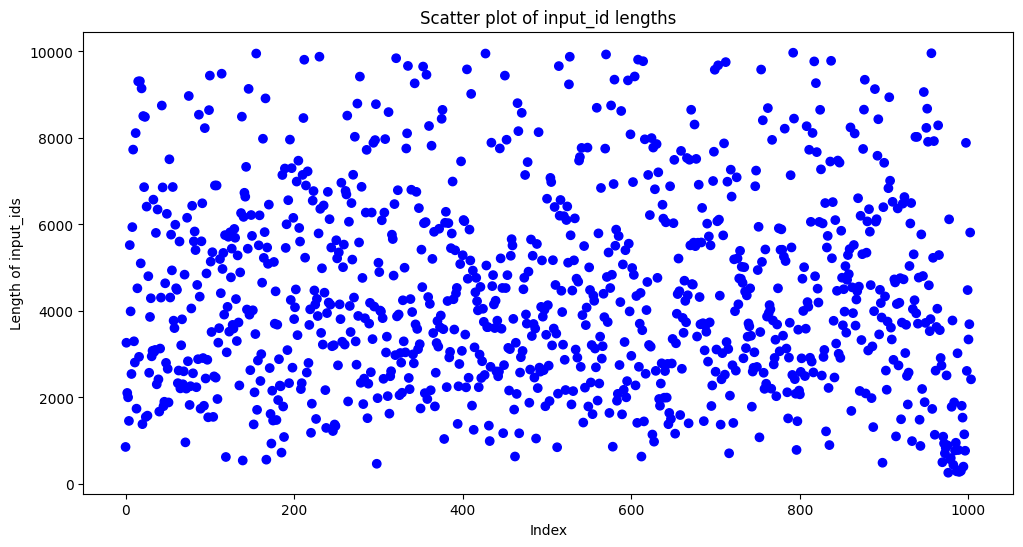

In [41]:
sie = []
note = []

for index, _ in enumerate(tokenized_custom_dataset):
    if len(_['input_ids']) == limit:
        note.append(index)
    sie.append(len(_['input_ids']))

# Create a color list: red if in note, blue otherwise
colors = ['red' if i in note else 'blue' for i in range(len(sie))]

plt.figure(figsize=(12, 6))
plt.scatter(range(len(sie)), sie, c=colors)
plt.xlabel("Index")
plt.ylabel("Length of input_ids")
plt.title("Scatter plot of input_id lengths")
plt.show()


# Task Completed